# <!-- TITLE --> [BHPD1] - Regression with a Dense Network (DNN)
<!-- DESC --> Simple example of a regression with LSST-DESC DC2 simulated data (BHPD)
<!-- AUTHOR : Sylvie Dagoret (CNRS/IJCLab) -->


- use fidle environnement `fidle23`

## Objectives :


https://github.com/sylvielsstfr/MyDP0LSS/blob/main/myDP0.2/PhotoZ/MLScikitL_Estimator/02_MLscikitL_PhotoZSimple_models.ipynb

In [1]:
def get_stats(z_spec,z_phot,slope=0.15):
    """
    input : 
       - z_spec : spectroscopic redshift or true redshift
       - z_phot : photo-z reedshift
       - slope : slope of line defining the outliers  3 x sigma_z with sigma_z = 5%, so slope = 3 x 0.05 = 0.15 
    """
    
    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > slope
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)
    

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    
     # overlay statistics with titles left-aligned and numbers right-aligned
    stats_txt = '\n'.join([
        'NMAD  = {:0.2f}'.format(nmad),
        'STDEV = {:0.2f}'.format(std_result),
        'BIAS  = {:0.2f}'.format(bias),
        'ETA   = {:0.2f}'.format(eta)
    ])
    
    
    return nmad,std_result,bias,eta,stats_txt

## Step 1 - Import and init

You can also adjust the verbosity by changing the value of TF_CPP_MIN_LOG_LEVEL :
- 0 = all messages are logged (default)
- 1 = INFO messages are not printed.
- 2 = INFO and WARNING messages are not printed.
- 3 = INFO , WARNING and ERROR messages are not printed.

In [2]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys
import h5py

import fidle

# Init Fidle environment
run_id, run_dir, datasets_dir = fidle.init('BHPD1')

2023-05-07 14:52:04.347429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<br>**FIDLE - Environment initialization**

Version              : 2.0b56
Run id               : BHPD1
Run dir              : ./run/BHPD1
Datasets dir         : /Users/dagoret/MacOSX/Fidle2023/fidle-tp/datasets-fidle
Start time           : 07/05/23 14:52:12
Hostname             : MacBook-Pro-de-admin.local (Darwin)
Tensorflow log level : Warning + Error  (=1)
Update keras cache   : False
Save figs            : ./run/BHPD1/figs (False)
tensorflow           : 2.12.0
numpy                : 1.24.2
sklearn              : 1.2.2
matplotlib           : 3.7.1
pandas               : 2.0.1


In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

Verbosity during training : 
- 0 = silent
- 1 = progress bar
- 2 = one line per epoch

In [3]:
fit_verbosity = 1

Override parameters (batch mode) - Just forget this cell

In [4]:
fidle.override('fit_verbosity')

## Step 2 - Retrieve data

### 2.1 - Option 1  : From Keras
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

In [5]:
input_train_file_h5 = "../data/test_dc2_training_9816.hdf5"
input_test_file_h5 = "../data/test_dc2_validation_9816.hdf5"

In [6]:
hftrain =  h5py.File(input_train_file_h5, 'r') 
hftest =  h5py.File(input_test_file_h5, 'r') 

In [7]:
def getdata(hf):
    key_sel = list(hf.keys())[0]
    group = hf.get(key_sel)
    
    mag_err_u_lsst = np.array(group.get("mag_err_u_lsst"))
    mag_err_g_lsst = np.array(group.get("mag_err_g_lsst"))
    mag_err_r_lsst = np.array(group.get("mag_err_r_lsst"))
    mag_err_i_lsst = np.array(group.get("mag_err_i_lsst"))
    mag_err_z_lsst = np.array(group.get("mag_err_z_lsst"))
    mag_err_y_lsst = np.array(group.get("mag_err_y_lsst"))
    mag_u_lsst =  np.array(group.get("mag_u_lsst"))
    mag_g_lsst =  np.array(group.get("mag_g_lsst"))
    mag_r_lsst =  np.array(group.get("mag_r_lsst"))
    mag_i_lsst =  np.array(group.get("mag_i_lsst"))
    mag_z_lsst =  np.array(group.get("mag_z_lsst"))
    mag_y_lsst =  np.array(group.get("mag_y_lsst"))
    redshift = np.array(group.get("redshift"))
    
    data = np.vstack((mag_u_lsst, 
                    mag_g_lsst, 
                    mag_r_lsst, 
                    mag_i_lsst, 
                    mag_z_lsst,
                    mag_y_lsst,
                    redshift)) 
    data = data.T
    indexes_bad = np.where(data[:,0]>40)[0]
    datacut = np.delete(data,indexes_bad,axis=0)
    features = datacut[:,0:-1]
    targets = datacut[:,-1]
    return features,targets    

In [8]:
x_train,y_train = getdata(hftrain)
x_test,y_test = getdata(hftest)

### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will **subtract the mean** and **divide by the standard deviation**.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [9]:
mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


## Step 4 - Build a model
About informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [10]:
def get_model_v1(shape):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(32, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(32, activation='relu', name='Dense_n3'))
  model.add(keras.layers.Dense(1, name='Output'))
  
  model.compile(optimizer = 'adam',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

## Step 5 - Train the model
### 5.1 - Get it

In [11]:
model=get_model_v1( (6,) )

model.summary()

img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
display(img)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 32)                224       
                                                                 
 Dense_n2 (Dense)            (None, 64)                2112      
                                                                 
 Dense_n3 (Dense)            (None, 32)                2080      
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 4,449
Trainable params: 4,449
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


None

### 5.2 - Train it

In [12]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 20,
                    verbose         = fit_verbosity,
                    validation_data = (x_test, y_test))

Epoch 1/100
476/476 [==============================] - 5s 8ms/step - loss: 0.1468 - mae: 0.2419 - mse: 0.1468 - val_loss: 0.0530 - val_mae: 0.1493 - val_mse: 0.0530
Epoch 2/100
476/476 [==============================] - 3s 7ms/step - loss: 0.0466 - mae: 0.1385 - mse: 0.0466 - val_loss: 0.0436 - val_mae: 0.1526 - val_mse: 0.0436
Epoch 3/100
476/476 [==============================] - 3s 6ms/step - loss: 0.0332 - mae: 0.1204 - mse: 0.0332 - val_loss: 0.0302 - val_mae: 0.1080 - val_mse: 0.0302
Epoch 4/100
476/476 [==============================] - 2s 4ms/step - loss: 0.0289 - mae: 0.1107 - mse: 0.0289 - val_loss: 0.0279 - val_mae: 0.1105 - val_mse: 0.0279
Epoch 5/100
476/476 [==============================] - 3s 6ms/step - loss: 0.0267 - mae: 0.1068 - mse: 0.0267 - val_loss: 0.0264 - val_mae: 0.1050 - val_mse: 0.0264
Epoch 6/100
476/476 [==============================] - 3s 6ms/step - loss: 0.0272 - mae: 0.1054 - mse: 0.0272 - val_loss: 0.0291 - val_mae: 0.1097 - val_mse: 0.0291
Epoch 7/10

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 0.0164
x_test / mae       : 0.0624
x_test / mse       : 0.0164


### 6.2 - Training history
What was the best result during our training ?

In [14]:
df=pd.DataFrame(data=history.history)
display(df)

,loss,mae,mse,val_loss,val_mae,val_mse
0,0.146753,0.241876,0.146753,0.053022,0.149335,0.053022
1,0.046608,0.138541,0.046608,0.043591,0.152614,0.043591
2,0.033151,0.120426,0.033151,0.030188,0.108038,0.030188
3,0.028865,0.110688,0.028865,0.027915,0.110454,0.027915
4,0.026654,0.106829,0.026654,0.026449,0.105004,0.026449
...,...,...,...,...,...,...
95,0.010486,0.057012,0.010486,0.020048,0.068815,0.020048
96,0.010579,0.057662,0.010579,0.018807,0.066569,0.018807
97,0.010851,0.057503,0.010851,0.015046,0.063100,0.015046
98,0.009975,0.056162,0.009975,0.015051,0.062949,0.015051


In [15]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 0.0581


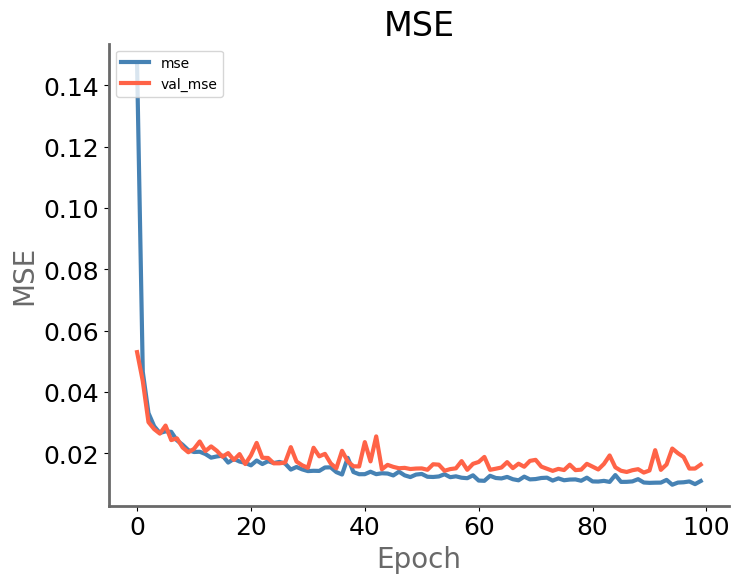

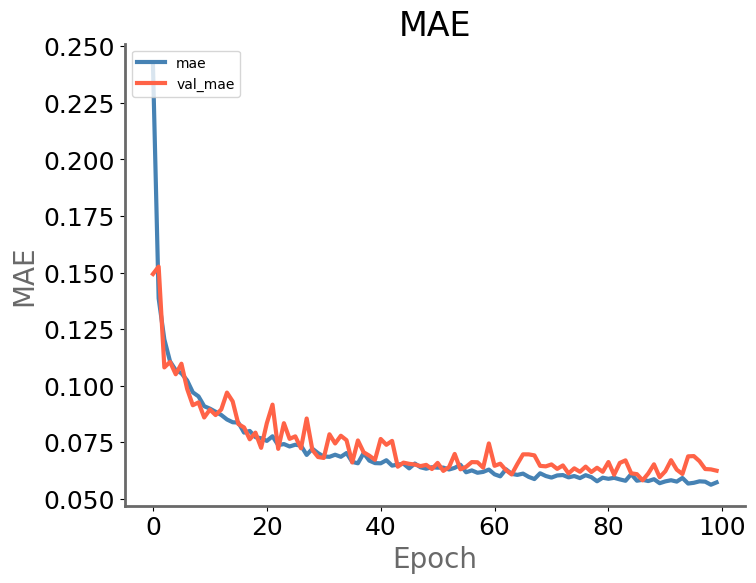

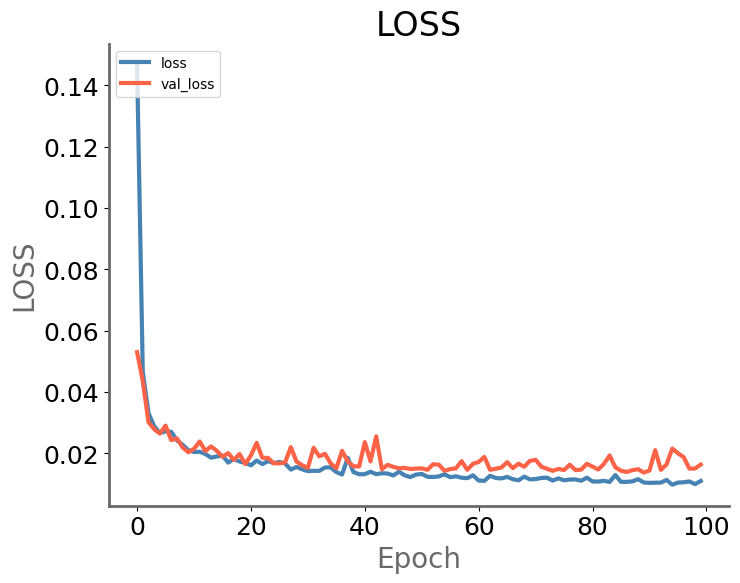

In [16]:
fidle.scrawler.history( history, plot={'MSE' :['mse', 'val_mse'],
                        'MAE' :['mae', 'val_mae'],
                        'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Make a prediction
The data must be normalized with the parameters (mean, std) previously used.

In [17]:
my_data=x_test

In [18]:
predictions = model.predict( my_data )

593/593 [==============================] - 1s 1ms/step


In [19]:
z_spec = y_test
z_phot = predictions.T

In [20]:
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 0.0779
Normalized MAD: 0.0274
Delta z >0.15(1+z) outliers:  2.300 percent
Median offset:  0.003 +/-  0.097


In [21]:
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords


In [22]:
def plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15):
    x = np.arange(zmin,zmax,zstep)
    outlier_upper = x + slope*(1+x)
    outlier_lower = x - slope*(1+x)
    return x,outlier_upper,outlier_lower

In [23]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

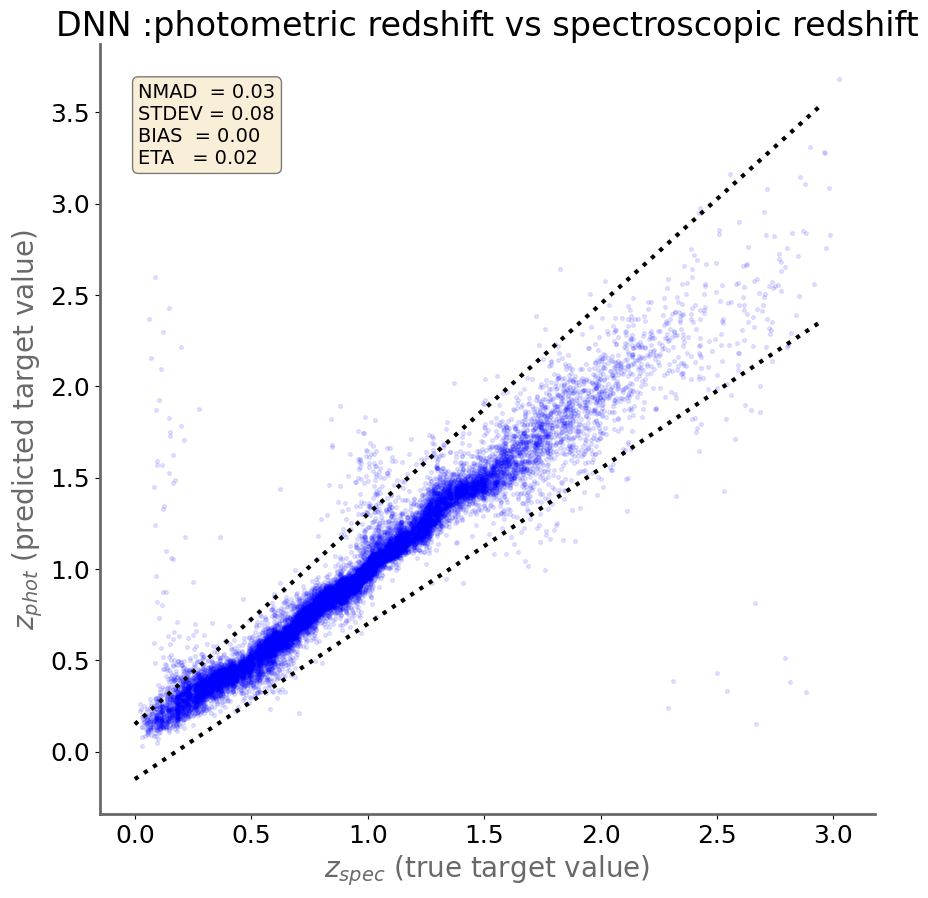

In [24]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')

In [25]:
fidle.end()

**End time :** 07/05/23 14:57:12  
**Duration :** 00:04:60 613ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)